In [26]:
import cv2
import numpy as np
import itertools
import matplotlib.pyplot as plt
import os

## rename tissues

In [27]:

def rename_tissues(folder_path):
    # Create a new directory for renamed images
    renamed_folder = os.path.join('tissues_renamed2')
    os.makedirs(renamed_folder, exist_ok=True)

    # Dictionary to store counts for each stain type
    tissue_stains = {'h&e': 0, 'sox': 0, 'melan': 0}
    
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.tiff', '.tif')):  
            if 'h&e' in filename.lower():
                stain_type = 'h&e'
            elif 'sox' in filename.lower():
                stain_type = 'sox'
            elif 'melan' in filename.lower():
                stain_type = 'melan'
            
            tissue_stains[stain_type] += 1
            
            # Create new name with the updated count
            new_name = f"{stain_type}{tissue_stains[stain_type]}.tiff" 
            original_image_path = os.path.join(folder_path, filename)  # Full path to the original image
            new_image_path = os.path.join(renamed_folder, new_name)  # Full path for the new image
            
            # Read the image
            img = cv2.imread(original_image_path, cv2.IMREAD_UNCHANGED)  # Use IMREAD_UNCHANGED for TIFF
            if img is not None:
                # Save the image with the new name, overwriting the original file
                cv2.imwrite(new_image_path, img)

In [28]:
folder_path = 'tissues_extracted'
rename_tissues(folder_path)

## grayscale contours

In [49]:
def grayscale_contour(folder_path):
    # Create a new directory for grayscale images with contours
    contours_folder = os.path.join('tissues_contours2')
    os.makedirs(contours_folder, exist_ok=True)
    
    # List to hold contours and corresponding image paths
    contours_list = []
    image_paths = []

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.tiff', '.tif')):  
            image_path = os.path.join(folder_path, filename)  # Full path to the image
            image = cv2.imread(image_path)  # Read the image
            
            if image is not None:
                # Convert to grayscale
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

                # Apply Canny edge detection
                edges = cv2.Canny(gray, threshold1=180, threshold2=220)

                # Find outer contours from the edges
                contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                # Filter contours by minimum area
                filtered_contours = [c for c in contours if cv2.contourArea(c) > 100]

                 # Print the number of filtered contours
                print(f"{filename}: Total contours after filtering: {len(filtered_contours)}")

                # Store contours and image path
                contours_list.append(filtered_contours)
                image_paths.append(image_path)

                # Draw the outer contours in green
                contour_image = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)  
                cv2.drawContours(contour_image, contours, -1, (0, 255, 0), thickness=2) 

                # Save the image with contours as a TIFF file
                contour_image_path = os.path.join(contours_folder, f"contour_{filename}")
                cv2.imwrite(contour_image_path, contour_image)
            else:
                print(f"Failed to read image: {image_path}")

    return contours_list, image_paths

In [50]:
folder_path = 'tissues_renamed2'  
contours_list, image_paths = grayscale_contour(folder_path)

melan1.tiff: Total contours after filtering: 597
h&e1.tiff: Total contours after filtering: 474
sox1.tiff: Total contours after filtering: 686
h&e6.tiff: Total contours after filtering: 478
h&e7.tiff: Total contours after filtering: 106
h&e4.tiff: Total contours after filtering: 187
melan4.tiff: Total contours after filtering: 645
h&e5.tiff: Total contours after filtering: 301
sox2.tiff: Total contours after filtering: 567
h&e2.tiff: Total contours after filtering: 469
melan3.tiff: Total contours after filtering: 766
melan2.tiff: Total contours after filtering: 491
h&e3.tiff: Total contours after filtering: 454


## match contours

In [60]:
def match_contours(image_paths, threshold):
    matches = []
    score_dict = {}  # Dictionary to store file pairs and their similarity scores

    # Create a dictionary to categorize images by stain type
    stain_groups = {'h&e': [], 'sox': [], 'melan': []}
    contours_list = []  # List to store contours for each image

    # Iterate through the images and extract contours
    for index, path in enumerate(image_paths):
        # Load the image and convert it to grayscale
        image = cv2.imread(path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply Gaussian Blur
        # gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # Apply thresholding to get a binary image
        _, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)

        # Apply morphological operations to reduce noise
        kernel = np.ones((3, 3), np.uint8)
        binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

        # Find all contours
        contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Approximate the contours and filter by area
        min_area = 1  # Set this based on your requirements
        approximated_contours = [cv2.approxPolyDP(c, 0.05 * cv2.arcLength(c, True), True) for c in contours]
        filtered_contours = [c for c in approximated_contours if cv2.contourArea(c) > min_area]

        contours_list.append(filtered_contours)

        # Count the number of contours detected
        num_contours = len(filtered_contours)
        print(f"{os.path.basename(path)}: {num_contours} contours detected.")

        # Categorize images by stain type
        if 'h&e' in path.lower():
            stain_groups['h&e'].append(index)
        elif 'sox' in path.lower():
            stain_groups['sox'].append(index)
        elif 'melan' in path.lower():
            stain_groups['melan'].append(index)


    # Compare contours between different stain types
    for stain1, stain2 in itertools.combinations(stain_groups.keys(), 2):
        for i in stain_groups[stain1]:
            for j in stain_groups[stain2]:
                if contours_list[i] and contours_list[j]:
                    # Select the largest contour
                    contour1 = max(contours_list[i], key=cv2.contourArea) if len(contours_list[i]) > 0 else None
                    contour2 = max(contours_list[j], key=cv2.contourArea) if len(contours_list[j]) > 0 else None
                    
                    if contour1 is not None and contour2 is not None:
                        score = cv2.matchShapes(contour1, contour2, cv2.CONTOURS_MATCH_I1, 0.0)
                        # Store the score in the dictionary
                        filename_pair = (os.path.basename(image_paths[i]), os.path.basename(image_paths[j]))
                        score_dict[filename_pair] = score
                        
                        if score < threshold:
                            matches.append((image_paths[i], image_paths[j], score))

    return matches, score_dict

In [61]:
def visualize_closest_matches(matches):
    closest_matches = {}

    # Create a dictionary to track the closest match for each image
    for img1_path, img2_path, score in matches:
        img1_name = os.path.basename(img1_path)
        
        # Check if we already have a closest match for img1_path
        if img1_name not in closest_matches or score < closest_matches[img1_name][1]:
            closest_matches[img1_name] = (img2_path, score)

    # Visualize the closest matches
    for img1_name, (img2_path, score) in closest_matches.items():
        img1_path = [match[0] for match in matches if os.path.basename(match[0]) == img1_name][0]  # Get the original path
        img2_name = os.path.basename(img2_path)
        
        img1 = cv2.imread(img1_path)
        img2 = cv2.imread(img2_path)

        # Resize images to have the same height
        height1, width1 = img1.shape[:2]
        height2, width2 = img2.shape[:2]
        new_height = min(height1, height2)
        
        img1_resized = cv2.resize(img1, (int(width1 * (new_height / height1)), new_height))
        img2_resized = cv2.resize(img2, (int(width2 * (new_height / height2)), new_height))

        # Create a combined image for visualization
        combined = np.hstack((img1_resized, img2_resized))
        
        # Display the images and the similarity score
        plt.imshow(cv2.cvtColor(combined, cv2.COLOR_BGR2RGB))
        plt.title(f'Similarity Score: {score:.3f}')
        plt.axis('off')
        
        # Display filenames
        plt.text(10, combined.shape[0] - 20, f'{img1_name}', color='white', fontsize=10)
        plt.text(img1_resized.shape[1] + 10, combined.shape[0] - 20, f'{img2_name}', color='black', fontsize=10)

        plt.show()


melan1.tiff: 4638 contours detected.
h&e1.tiff: 43 contours detected.
sox1.tiff: 4897 contours detected.
h&e6.tiff: 80 contours detected.
h&e7.tiff: 102 contours detected.
h&e4.tiff: 5 contours detected.
melan4.tiff: 3584 contours detected.
h&e5.tiff: 7 contours detected.
sox2.tiff: 4040 contours detected.
h&e2.tiff: 34 contours detected.
melan3.tiff: 5093 contours detected.
melan2.tiff: 2446 contours detected.
h&e3.tiff: 388 contours detected.


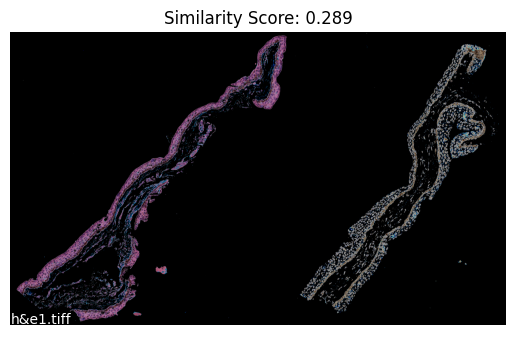

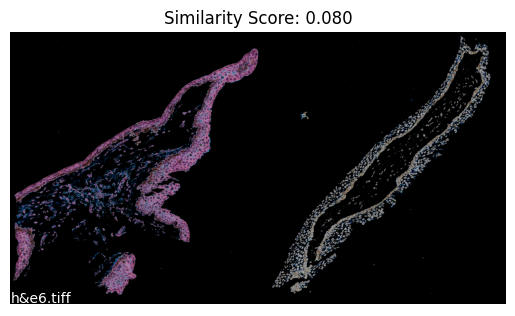

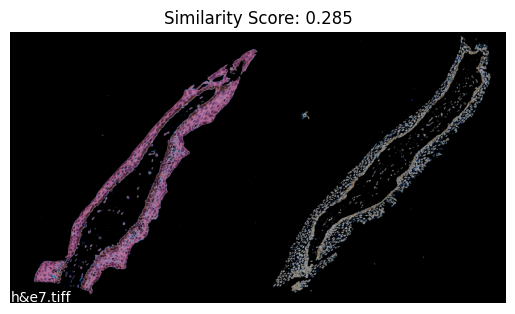

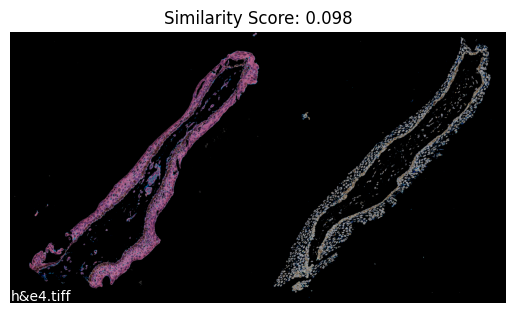

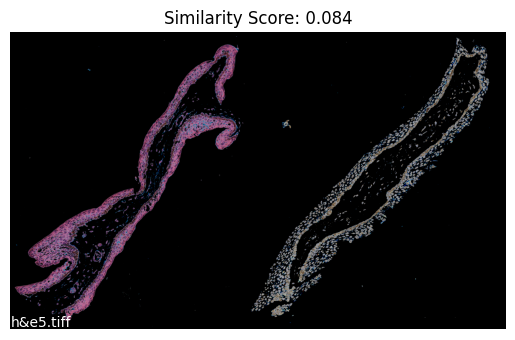

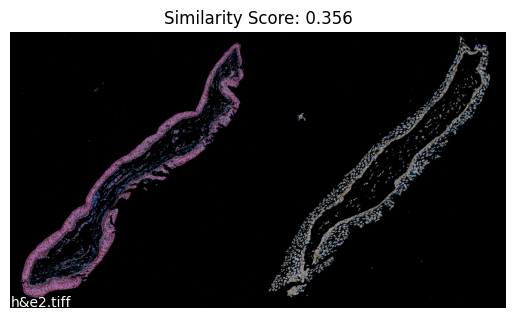

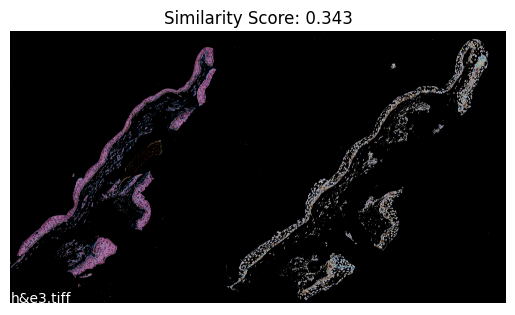

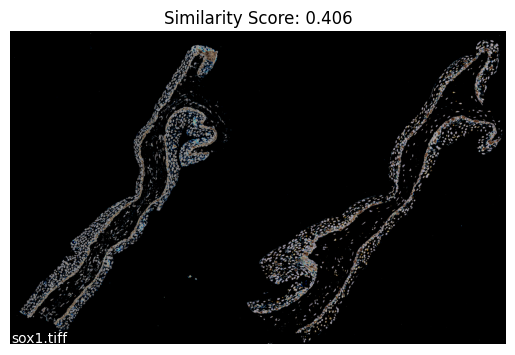

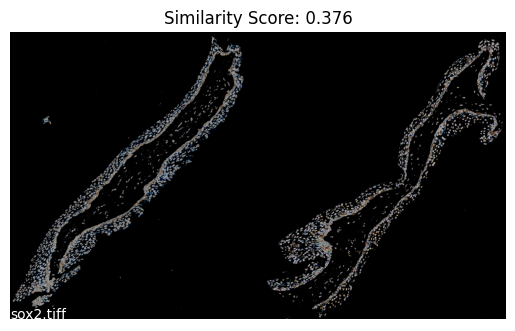

In [62]:
threshold = 0.9

matches, dict = match_contours(image_paths, threshold)
visualize_closest_matches(matches)